## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
!pip install tensorflow
!pip install scikeras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [78]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader.

In [27]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import pandas as pd

stk_tickers = ['TSM', 'NVDA']
ccy_tickers = ['DEXCHUS']
idx_tickers = ['^TWII','^SOX', '^VIX',]

# Downloading data using yfinance for stock tickers
stk_data = yf.download(stk_tickers, period="max") # Downloading maximum available data

# Continue to use pandas_datareader for other data sources
ccy_data = web.DataReader(ccy_tickers, 'fred')
# idx_data = web.DataReader(idx_tickers, 'fred')
idx_data = yf.download(idx_tickers, period="max")

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [32]:
# Check for missing data
print("\nData overview:")
print(f"Stock data missing values: {stk_data['Close'].isna().sum().sum()}")
print(f"Index data missing values: {idx_data['Close'].isna().sum().sum()}")
print(f"Currency data missing values: {ccy_data.isna().sum().sum()}")



Data overview:
Stock data missing values: 323
Index data missing values: 3837
Currency data missing values: 56


In [28]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business Day Returns    
    c. USD/JPY 5 Business Day Returns    
    d. GBP/USD 5 Business Day Returns    
    e. S&P 500 5 Business Day Returns    
    f. Dow Jones 5 Business Day Returns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [33]:
Y = np.log(stk_data.loc[:, ('Close', 'TSM')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Close', 'NVDA')]).diff(return_period)
X1 = X1.to_frame()
# X1.columns = X1.columns.droplevel()
X1.columns = ['NVDA']

# X2: Currency returns
X2 = ccy_data.copy()
# Only apply log diff if we have data
if not X2.empty and not X2.isna().all().all():
    X2 = np.log(X2).diff(return_period)

# X3: Index returns
# Create a dataframe with Close prices for all indices
X3 = pd.DataFrame()
for idx in idx_tickers:
    X3[idx] = idx_data['Close'][idx]
X3 = np.log(X3).diff(return_period)

# X4: TSM's own historical returns at different timeframes
X4 = pd.DataFrame()
tsm_close = stk_data.loc[:, ('Close', 'TSM')]
for i, period in enumerate([return_period, return_period*3, return_period*6, return_period*12]):
    period_name = f"TSM_{period}D"
    X4[period_name] = np.log(tsm_close).diff(period)

# Combine all features
X = pd.concat([X1, X2, X3, X4], axis=1)

# Create final dataset by aligning dates and dropping missing values
dataset = pd.concat([Y, X], axis=1).dropna()
print(f"\nFinal dataset shape: {dataset.shape}")

# Extract X and Y from dataset
Y_final = dataset[Y.name]
X_final = dataset.drop(columns=[Y.name])


Final dataset shape: (1035, 10)


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [34]:
pd.set_option('display.precision', 3)
dataset.describe()

,TSM_pred,NVDA,DEXCHUS,^TWII,^SOX,^VIX,TSM_5D,TSM_15D,TSM_30D,TSM_60D
count,1035.000,1035.000,1.035e+03,1035.000,1035.000,1035.000,1035.000,1035.000,1035.000,1035.000
mean,0.006,0.012,1.046e-04,0.002,0.004,-0.003,0.005,0.014,0.028,0.058
std,0.049,0.069,6.046e-03,0.024,0.044,0.147,0.048,0.085,0.122,0.173
min,-0.150,-0.251,-3.479e-02,-0.116,-0.167,-0.622,-0.150,-0.225,-0.287,-0.380
25%,-0.027,-0.032,-2.570e-03,-0.011,-0.024,-0.084,-0.027,-0.042,-0.060,-0.062
50%,0.006,0.012,2.397e-04,0.004,0.006,-0.011,0.004,0.009,0.023,0.057
75%,0.033,0.054,2.835e-03,0.018,0.033,0.074,0.032,0.069,0.106,0.176
max,0.219,0.264,3.026e-02,0.093,0.153,0.843,0.219,0.303,0.404,0.474


In [35]:
dataset.head()

,TSM_pred,NVDA,DEXCHUS,^TWII,^SOX,^VIX,TSM_5D,TSM_15D,TSM_30D,TSM_60D
2020-04-07,-0.001,-0.017,-5.097e-03,0.029,0.048,-0.137,0.040,0.033,-0.071,-0.159
2020-04-08,0.041,0.094,-4.801e-03,0.048,0.139,-0.275,0.078,0.134,-0.081,-0.168
2020-04-13,0.076,0.101,-5.573e-03,0.028,0.019,-0.094,0.035,0.091,-0.090,-0.171
2020-04-14,0.015,0.056,4.399e-04,0.033,0.067,-0.212,0.013,0.112,-0.091,-0.139
2020-04-15,0.064,0.081,2.123e-04,0.030,0.005,-0.060,-0.001,0.016,-0.091,-0.156


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

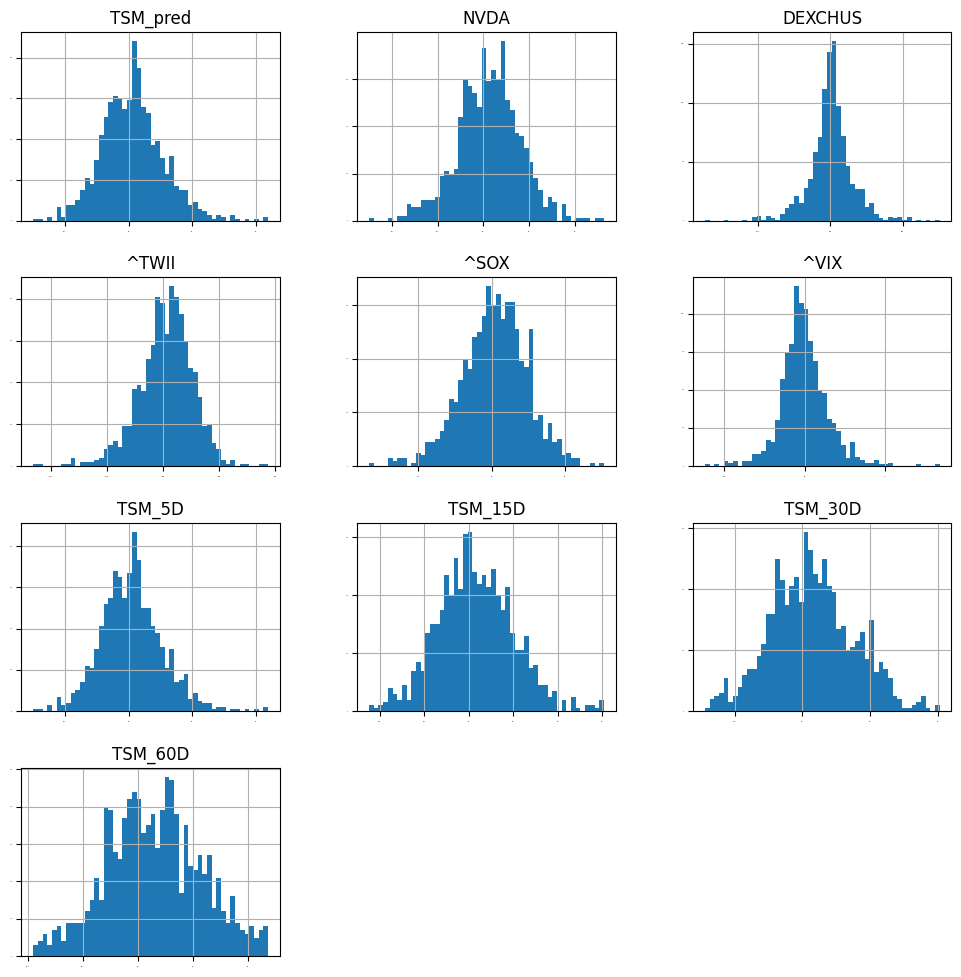

In [36]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

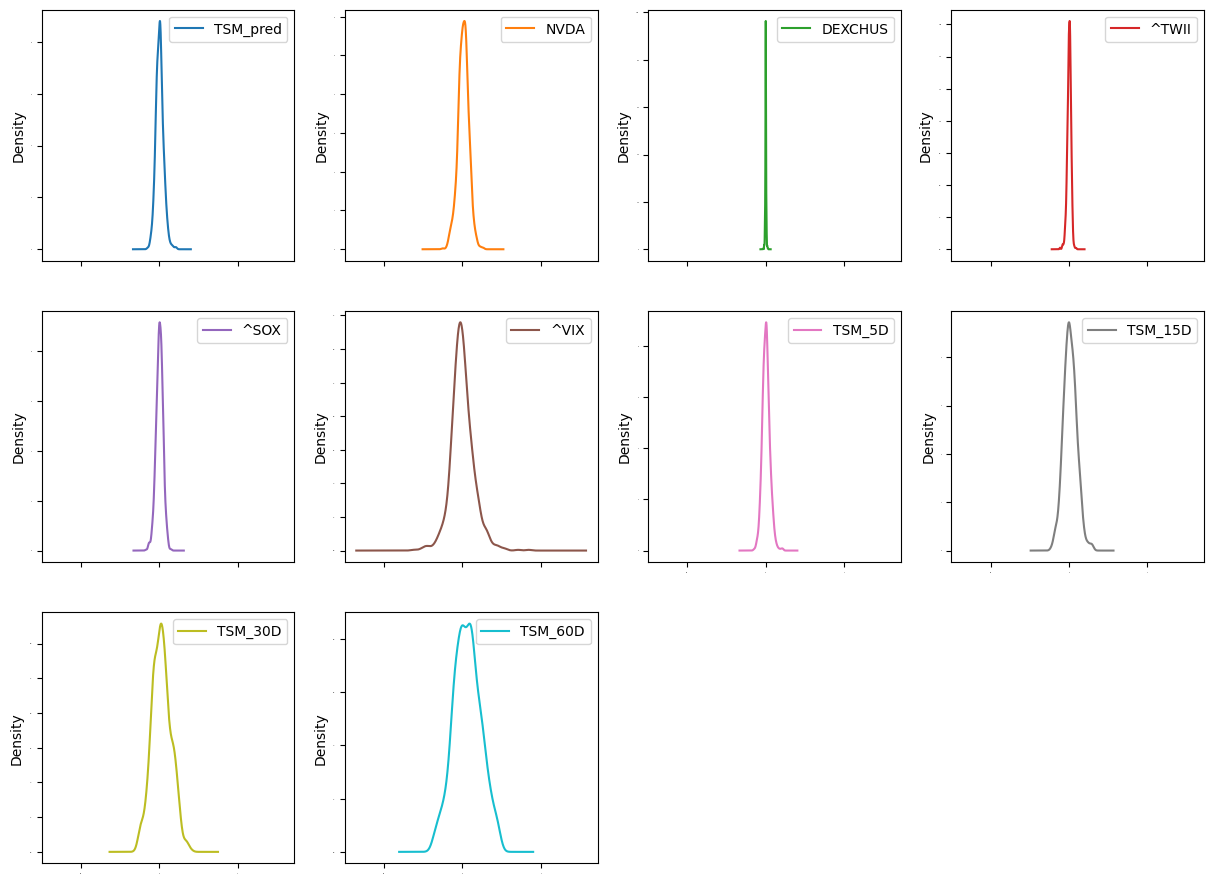

In [37]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<Axes: title={'center': 'Correlation Matrix'}>

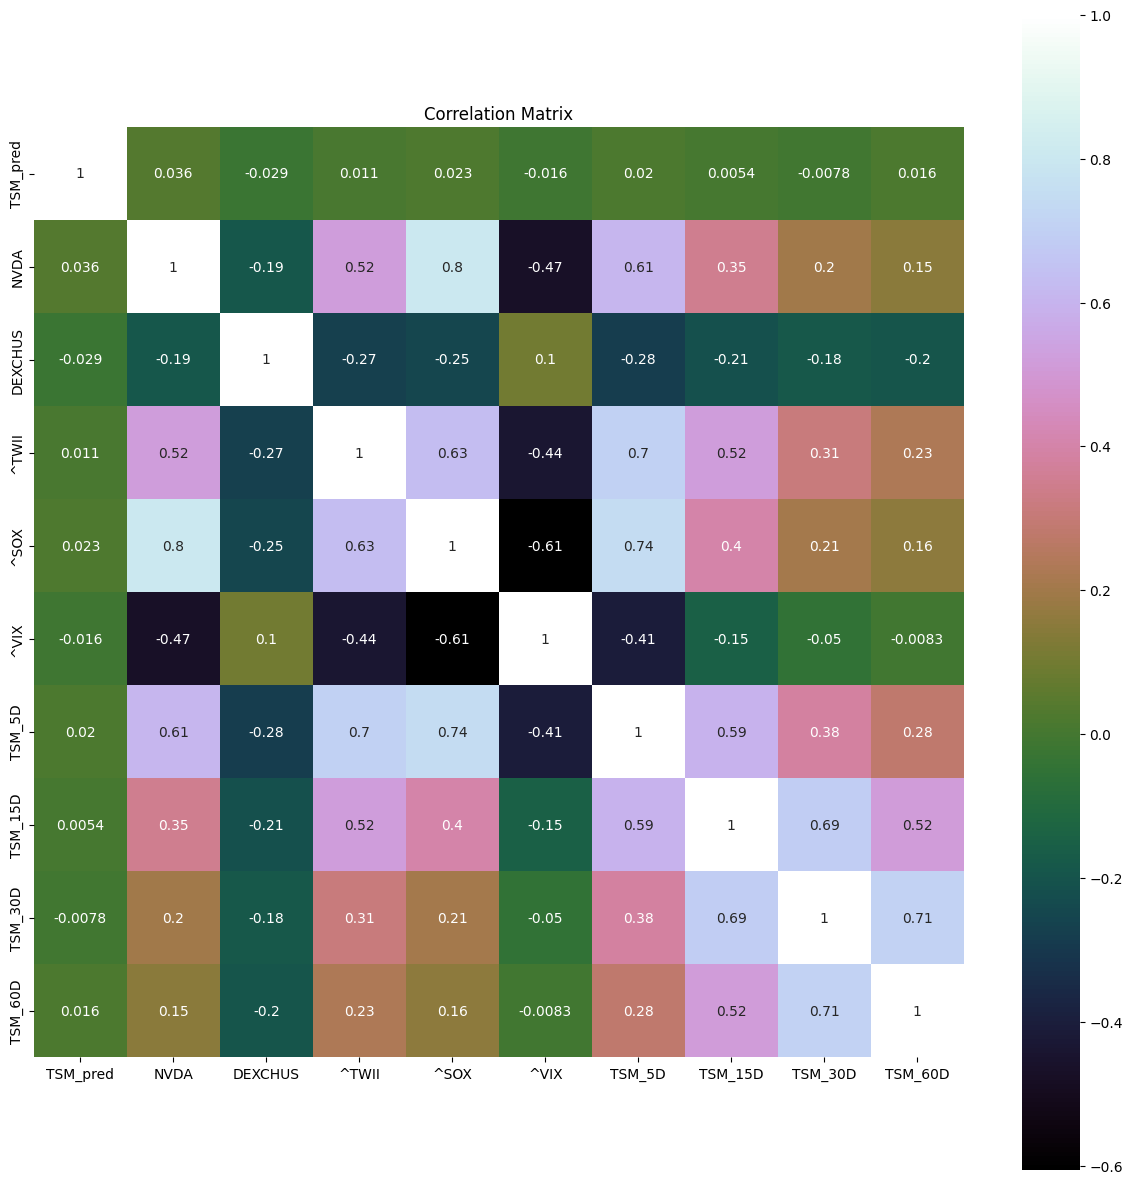

In [38]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15 days, 30 days and 60 days return of MSFT.

<Figure size 1500x1500 with 0 Axes>

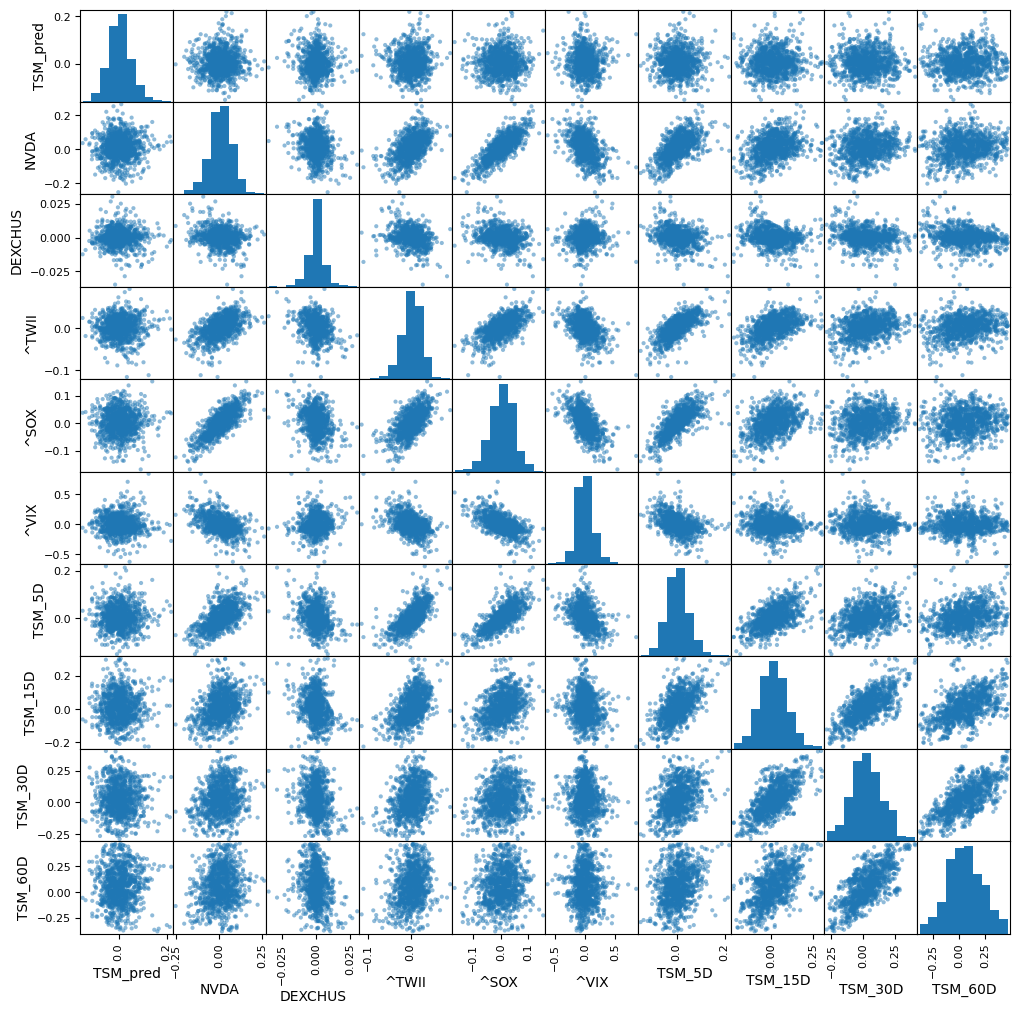

In [39]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable with the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series

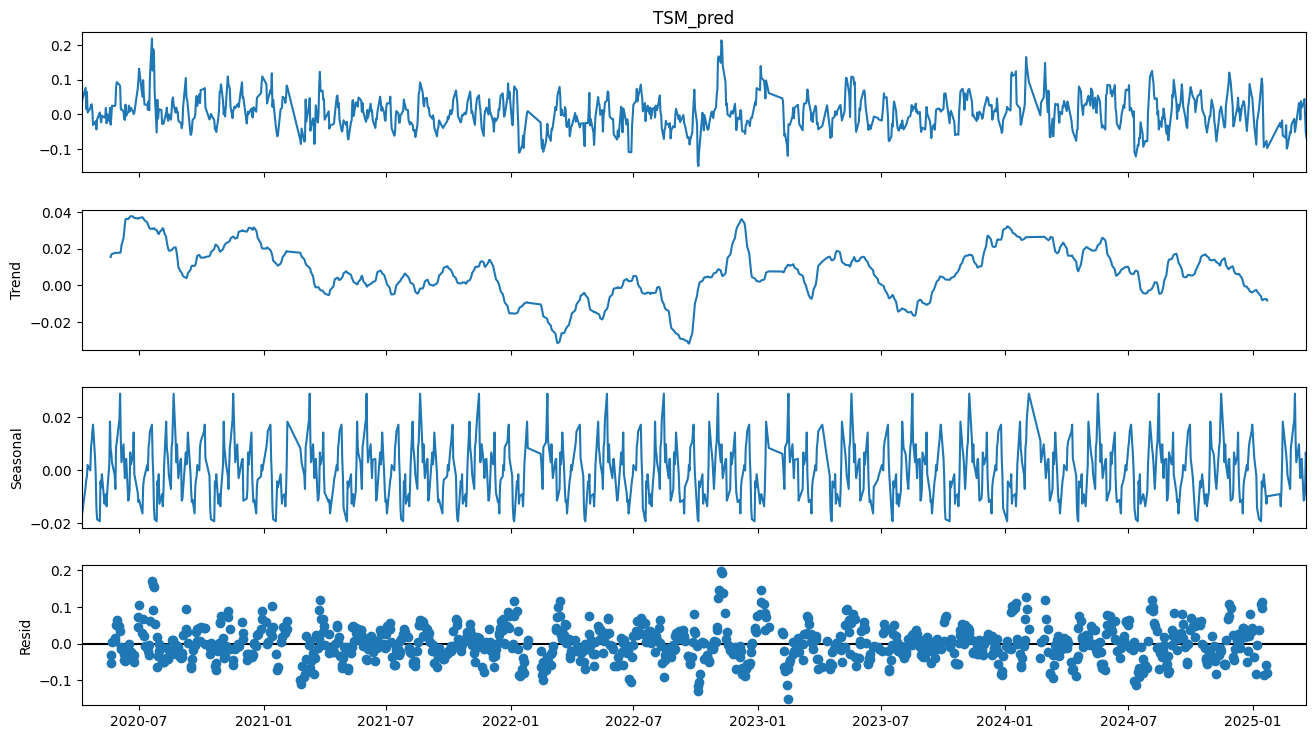

In [41]:
res = sm.tsa.seasonal_decompose(Y_final,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance.

In [43]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X_final,Y_final)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
NVDA,1.365
DEXCHUS,0.846
^SOX,0.527
TSM_5D,0.415
TSM_60D,0.277
^VIX,0.273
^TWII,0.120
TSM_30D,0.062
TSM_15D,0.030


We see that MSFT_DT seems to be the most important feature and vix being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [59]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X_final) * (1-validation_size))
X_train, X_test = X_final[0:train_size], X_final[train_size:len(X_final)]
Y_train, Y_test = Y_final[0:train_size], Y_final[train_size:len(X_final)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [60]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error.
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [61]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [62]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [63]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [64]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)


    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002386 (0.000293) 0.002336 0.002842
LASSO: 0.002386 (0.000293) 0.002380 0.002575
EN: 0.002386 (0.000293) 0.002380 0.002575
KNN: 0.001911 (0.000406) 0.001180 0.003507
CART: 0.003700 (0.000544) 0.000000 0.004650
SVR: 0.002453 (0.000373) 0.002251 0.003015
MLP: 0.002392 (0.000318) 0.002310 0.002944
ABR: 0.002226 (0.000311) 0.001876 0.002982
GBR: 0.002144 (0.000376) 0.000972 0.003069
RFR: 0.001896 (0.000370) 0.000255 0.002933
ETR: 0.001630 (0.000305) 0.000000 0.002932


#### K Fold results

We being by looking at the K Fold results

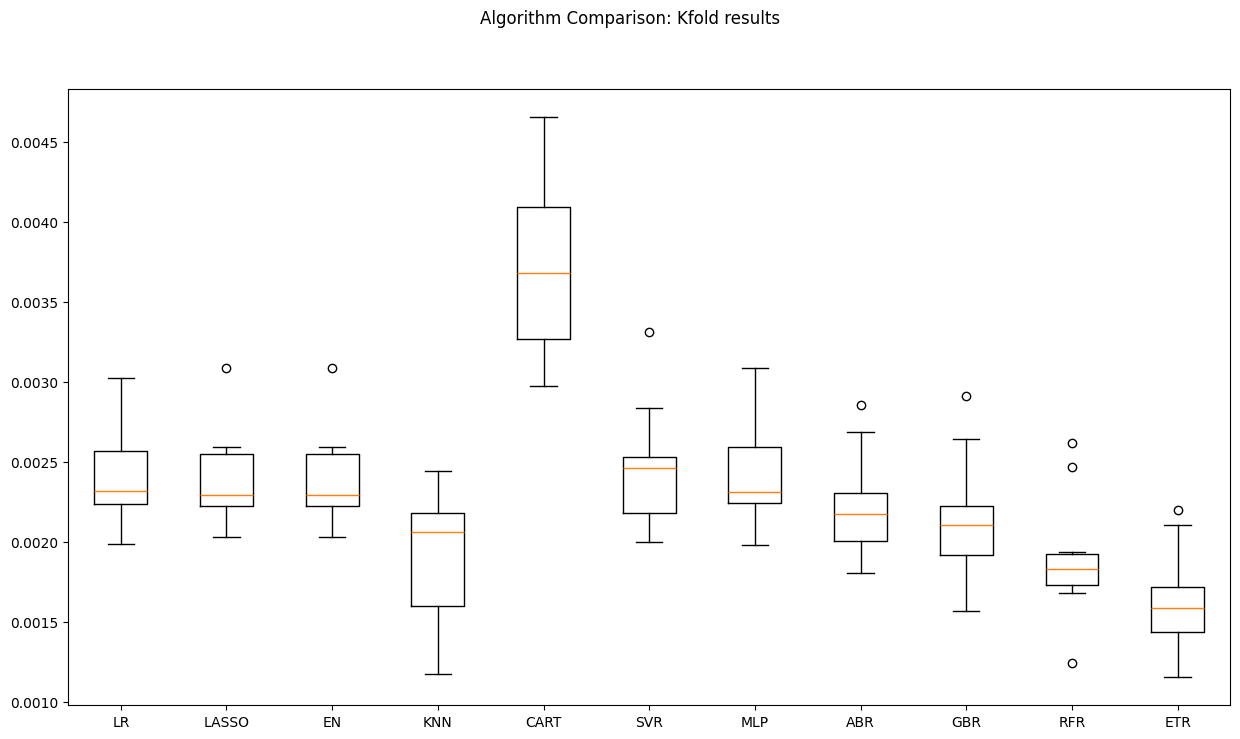

In [65]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

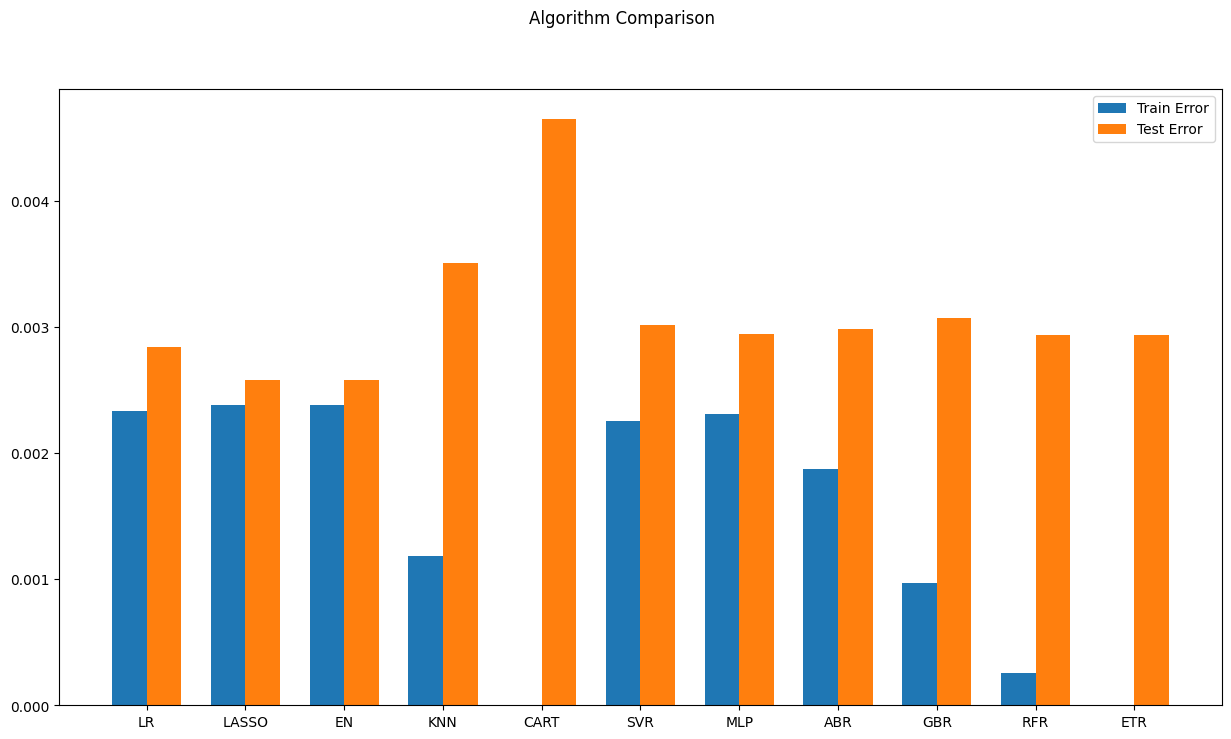

In [66]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [67]:
X_train_ARIMA=X_train.loc[:, ['NVDA', 'DEXCHUS', '^TWII', '^SOX', '^VIX']]
X_test_ARIMA=X_test.loc[:, ['NVDA', 'DEXCHUS', '^TWII', '^SOX', '^VIX']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X_final)

In [68]:
# ARIMA(ARIMAX)
from statsmodels.tsa.arima.model import ARIMA
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1, 0, 0)) #(1,0,0)is an initial guess
model_fit = modelARIMA.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


0.002550231953372591

###  LSTM Model

In [70]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X_final.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X_final)[X_train.shape[0]+i-1:X_final.shape[0]+i+1-seq_len, :]


In [71]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer)
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0.0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


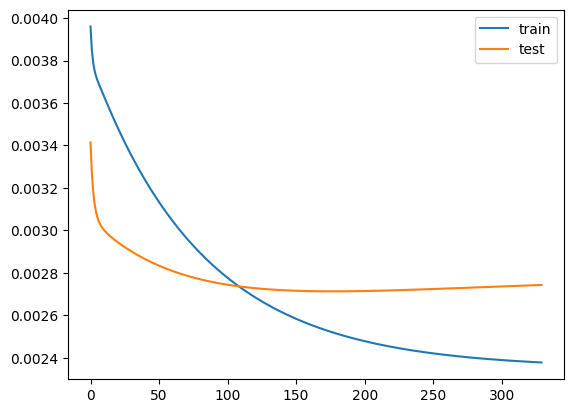

In [72]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [73]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)
error_Test_LSTM

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


0.002743273542285852

#### Append to previous results

In [74]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

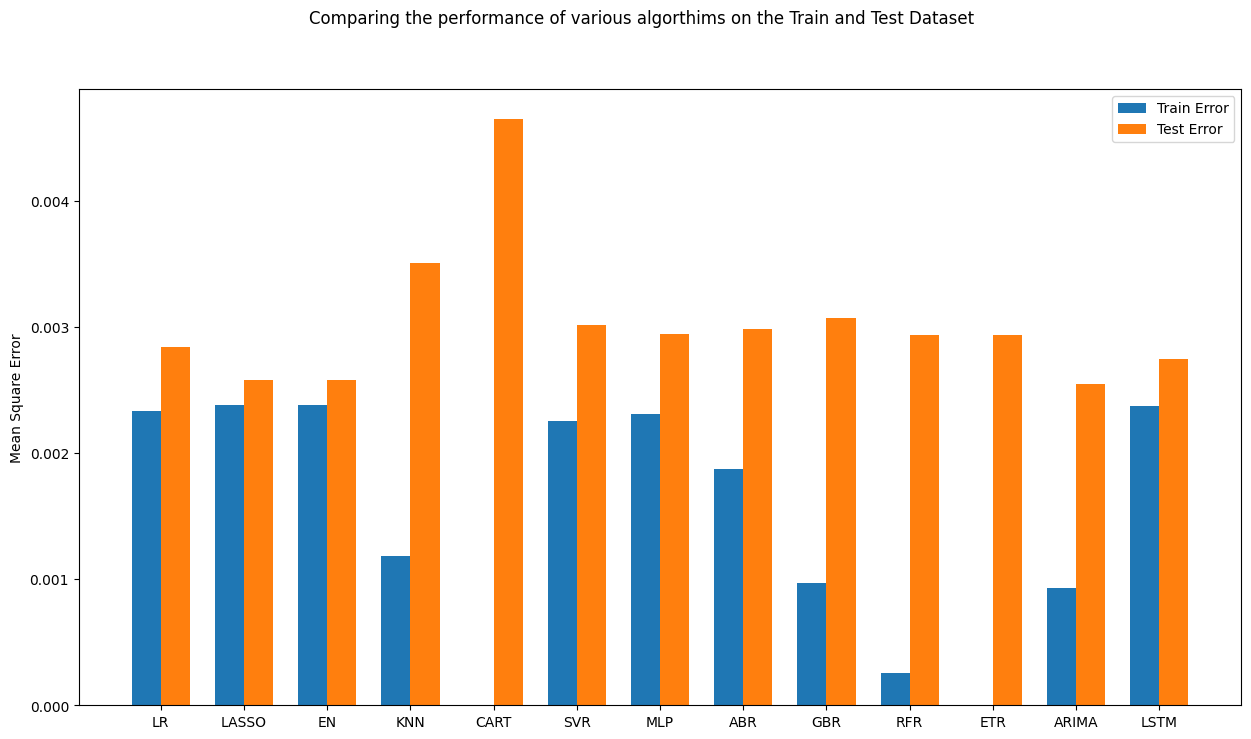

In [75]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [79]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0023540
ARIMA(0, 0, 1) MSE=0.0013252
ARIMA(0, 1, 0) MSE=0.0010269
ARIMA(0, 1, 1) MSE=0.0010246
ARIMA(1, 0, 0) MSE=0.0009309
ARIMA(1, 0, 1) MSE=0.0009283
ARIMA(1, 1, 0) MSE=0.0010249
ARIMA(1, 1, 1) MSE=0.0009381
ARIMA(2, 0, 0) MSE=0.0009279
ARIMA(2, 0, 1) MSE=0.0009260
ARIMA(2, 1, 0) MSE=0.0010207
ARIMA(2, 1, 1) MSE=0.0009398
Best ARIMA(2, 0, 1) MSE=0.0009260


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [80]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,0])
model_fit_tuned = modelARIMA_tuned.fit()

In [81]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.002550231953372591


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose.

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [82]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

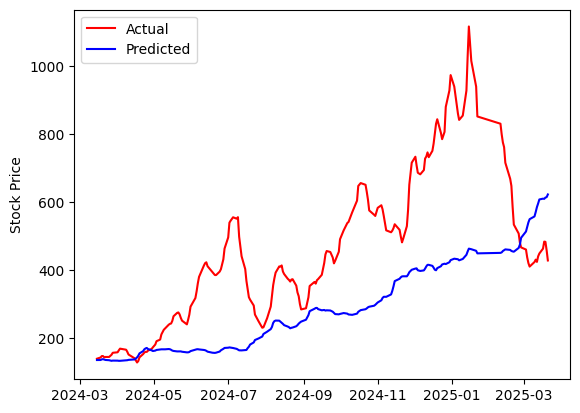

In [84]:
initial_price = stk_data.loc[Y_test.index[0], ('Close', 'TSM')]  # Get initial price from stk_data

# Calculate actual prices from returns
actual_prices = initial_price * np.exp(Y_test).cumprod()

# Calculate predicted prices from predicted returns
predicted_tuned.index = Y_test.index
predicted_prices = initial_price * np.exp(predicted_tuned).cumprod()

# Plotting
pyplot.plot(actual_prices, 'r', label='Actual')
pyplot.plot(predicted_prices, 'b', label='Predicted')
pyplot.rcParams["figure.figsize"] = (8, 5)
pyplot.ylabel('Stock Price')  # Update y-axis label
pyplot.legend()
pyplot.show()

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promising modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.